# Import Library

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
#from pmdarima import auto_arima

# Load Data

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/store5.csv")
print(df.shape)
df.head()

(55572, 7)


,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,1452,2013-01-01,5,AUTOMOTIVE,0.0,0,NaN
1,1453,2013-01-01,5,BABY CARE,0.0,0,NaN
2,1454,2013-01-01,5,BEAUTY,0.0,0,NaN
3,1455,2013-01-01,5,BEVERAGES,0.0,0,NaN
4,1456,2013-01-01,5,BOOKS,0.0,0,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55572 entries, 0 to 55571
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           55572 non-null  int64  
 1   date         55572 non-null  object 
 2   store_nbr    55572 non-null  int64  
 3   family       55572 non-null  object 
 4   sales        55572 non-null  float64
 5   onpromotion  55572 non-null  int64  
 6   dcoilwtico   38379 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 3.0+ MB


In [5]:
df.describe()

,id,store_nbr,sales,onpromotion,dcoilwtico
count,5.557200e+04,55572.0,55572.000000,55572.000000,38379.000000
mean,1.501021e+06,5.0,280.580231,2.687864,67.925589
std,8.662894e+05,0.0,652.588149,11.748996,25.666659
min,1.452000e+03,5.0,0.000000,0.000000,26.190000
25%,7.512365e+05,5.0,1.000000,0.000000,46.380000
50%,1.501021e+06,5.0,19.000000,0.000000,53.330000
75%,2.250806e+06,5.0,237.000000,0.000000,95.800000
max,3.000590e+06,5.0,8216.620000,182.000000,110.620000


# EDA

### Define Target Variable

---



In [6]:
# Kita memilih 'sales' karena ini nilai yang ingin diprediksi (jumlah penjualan per hari per toko dan kategori produk).

target = 'sales'
print("Target variable:", target)

Target variable: sales


### Explore Each Variables

#### Sales Trend

<Axes: title={'center': 'Tren Penjualan Harian'}, xlabel='date'>

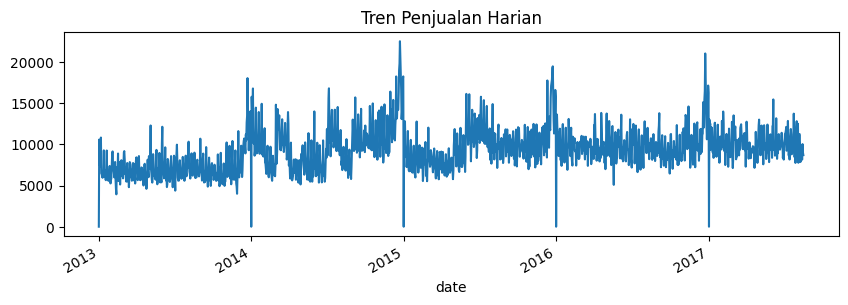

In [7]:
df['date'] = pd.to_datetime(df['date'])
df.groupby('date')['sales'].sum().plot(figsize=(10,3), title="Tren Penjualan Harian")

* Ada beberapa titik anomali/outlier kemungkinan hari libur besar.

<Axes: title={'center': 'Rata-rata Penjualan per Hari (0=Senin)'}, xlabel='dayofweek'>

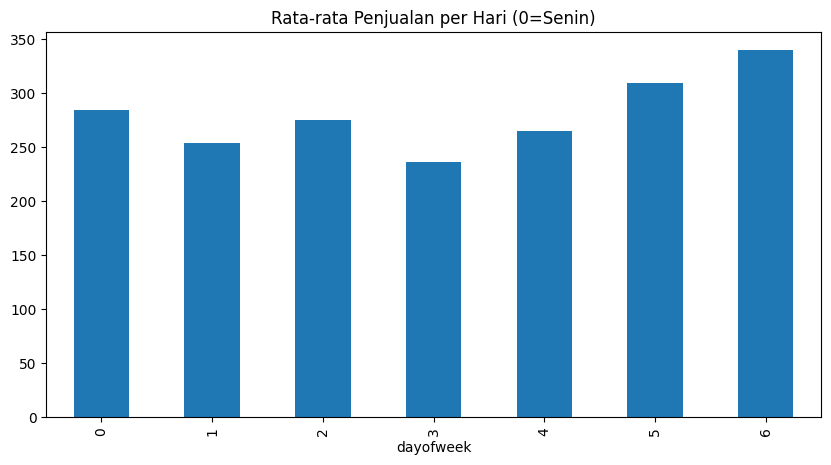

In [8]:
df['month'] = df['date'].dt.month
df['dayofweek'] = df['date'].dt.dayofweek

# Rata-rata penjualan per hari dalam minggu
df.groupby('dayofweek')['sales'].mean().plot(kind='bar', figsize=(10,5), title="Rata-rata Penjualan per Hari (0=Senin)")


* Penjualan cenderung lebih tinggi di akhir pekan, kemungkinan karena aktivitas belanja keluarga.

<Axes: title={'center': 'Rata-rata Penjualan per Bulan'}, xlabel='month'>

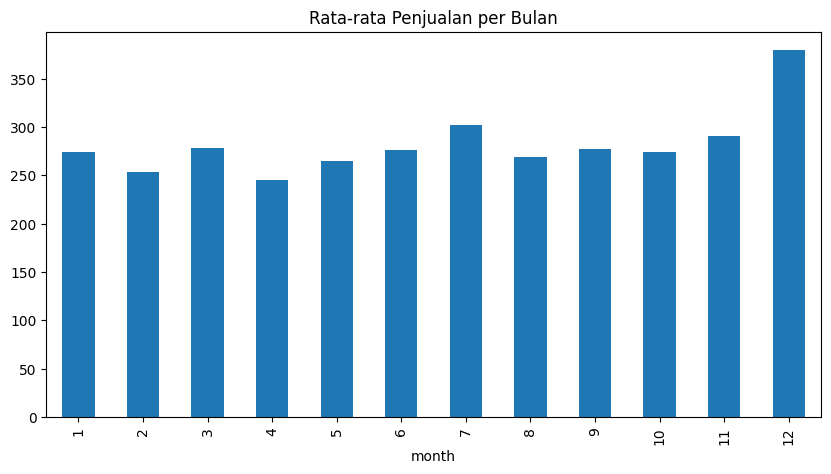

In [9]:
df.groupby('month')['sales'].mean().plot(kind='bar', figsize=(10,5), title="Rata-rata Penjualan per Bulan")

* Ada pola musiman tahunan. Bisnis harus memperhatikan stok lebih banyak menjelang Desember.

#### Top 10 Product Families

In [10]:
print("Jumlah kategori produk (family):", df['family'].nunique())

Jumlah kategori produk (family): 33


In [11]:
# tampilkan 10 contoh family
print("Daftar family:", df['family'].unique()[:10])

Daftar family: ['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI']


<Axes: title={'center': 'Top 10 Product Family berdasarkan Total Sales'}, xlabel='family'>

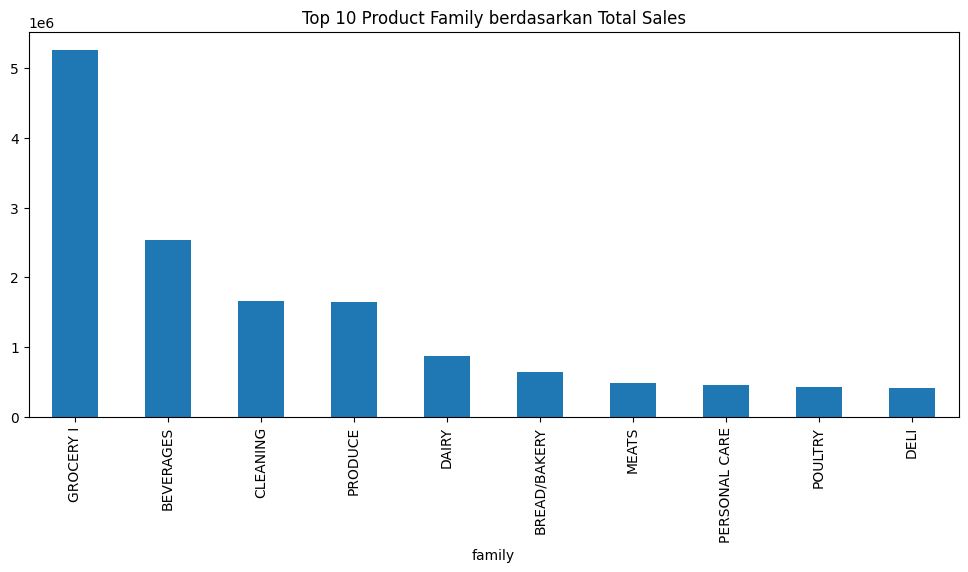

In [12]:
# Hitung total sales per family
top_family = df.groupby('family')['sales'].sum().sort_values(ascending=False)

# Tampilkan 10 besar
top_family.head(10).plot(kind='bar', figsize=(12,5), title="Top 10 Product Family berdasarkan Total Sales")

* Dalam analisis ini, kita hanya akan fokus pada produk dengan kategori Bread/Bakery.

#### Correlation Analysis

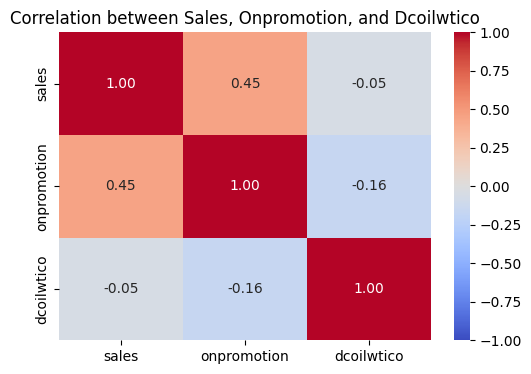

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pilih kolom yang relevan untuk dicek korelasinya
corr_cols = ['sales', 'onpromotion', 'dcoilwtico']
corr = df[corr_cols].corr()

# Plot heatmap korelasi
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation between Sales, Onpromotion, and Dcoilwtico")
plt.show()


- Sales vs Onpromotion (0.45) Ada korelasi sedang (positif). Artinya, jika ada lebih banyak produk yang dipromosikan, penjualan cenderung meningkat.

* Sales vs Dcoilwtico (-0.05) Hampir tidak ada korelasi (mendekati 0). Harga minyak dunia tidak berpengaruh signifikan terhadap penjualan pada dataset ini.

* Onpromotion vs Dcoilwtico (-0.16) Korelasi sangat lemah negatif, bisa diabaikan.

Kedua kolom dihapus pada tahap preprocessing, agar analisis fokus pada pola penjualan historis tanpa faktor eksternal.

# Data Preprocessing

#### Data Filtering

In [14]:
# Filter hanya untuk family = 'Bread/Bakery'
df['family'] = df['family'].str.strip()   # hapus spasi
df = df[df['family'].str.lower() == 'bread/bakery'.lower()].copy()

#### Correlation

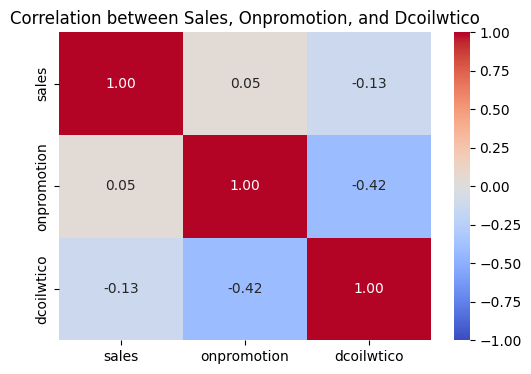

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pilih kolom yang relevan untuk dicek korelasinya
corr_cols = ['sales', 'onpromotion', 'dcoilwtico']
corr = df[corr_cols].corr()

# Plot heatmap korelasi
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation between Sales, Onpromotion, and Dcoilwtico")
plt.show()

In [16]:
# Drop kolom yang tidak digunakan.
df = df.drop(columns=['onpromotion', 'dcoilwtico', 'month', 'dayofweek'], errors='ignore')

In [17]:
# Lihat 5 baris pertama
df.head()

,id,date,store_nbr,family,sales
5,1457,2013-01-01,5,BREAD/BAKERY,0.000
38,3239,2013-01-02,5,BREAD/BAKERY,566.917
71,5021,2013-01-03,5,BREAD/BAKERY,377.887
104,6803,2013-01-04,5,BREAD/BAKERY,335.761
137,8585,2013-01-05,5,BREAD/BAKERY,402.286


In [18]:
# Lihat 5 baris terakhir
df.tail()

,id,date,store_nbr,family,sales
55412,2993435,2017-08-11,5,BREAD/BAKERY,312.186
55445,2995217,2017-08-12,5,BREAD/BAKERY,247.893
55478,2996999,2017-08-13,5,BREAD/BAKERY,366.425
55511,2998781,2017-08-14,5,BREAD/BAKERY,393.150
55544,3000563,2017-08-15,5,BREAD/BAKERY,334.434


In [19]:
# Pastikan hanya ada 1 kategori family
print("Kategori unik pada kolom 'family':", df['family'].unique())

Kategori unik pada kolom 'family': ['BREAD/BAKERY']


#### (re) Statistic Descriptive

<Axes: title={'center': 'Rata-rata Penjualan per Hari (0=Senin) setelah filtering'}, xlabel='dayofweek'>

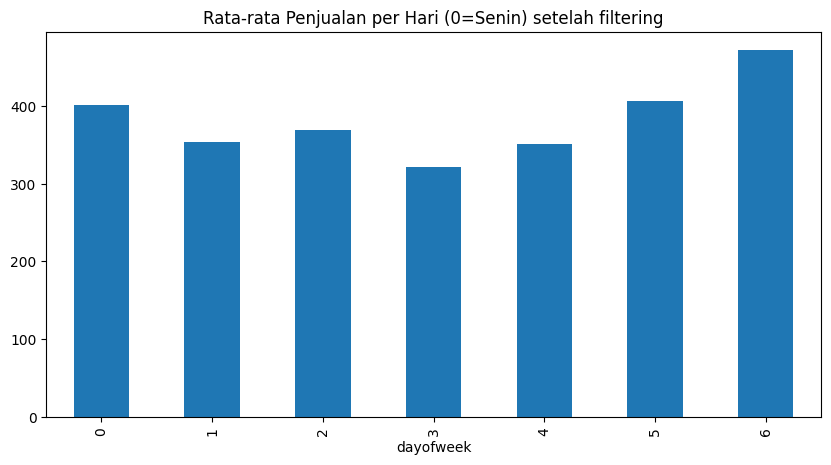

In [20]:
df['month'] = df['date'].dt.month
df['dayofweek'] = df['date'].dt.dayofweek

# Rata-rata penjualan per hari dalam minggu
df.groupby('dayofweek')['sales'].mean().plot(kind='bar', figsize=(10,5), title="Rata-rata Penjualan per Hari (0=Senin) setelah filtering")

<Axes: title={'center': 'Rata-rata Penjualan per Bulan setelah filtering'}, xlabel='month'>

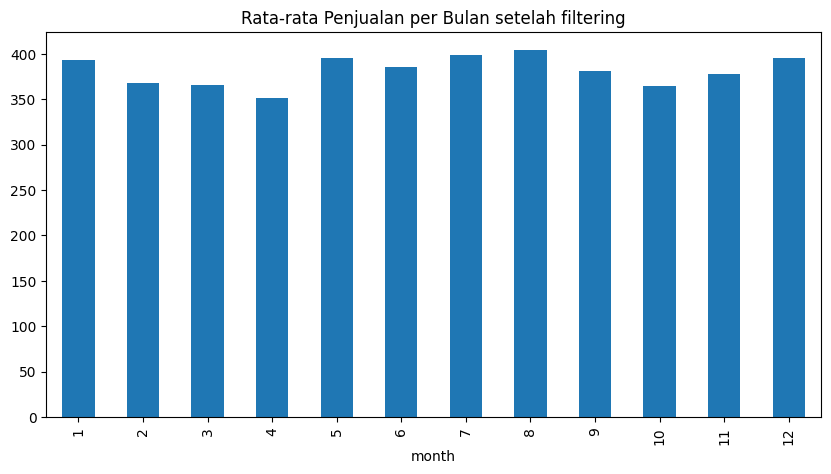

In [21]:
df.groupby('month')['sales'].mean().plot(kind='bar', figsize=(10,5), title="Rata-rata Penjualan per Bulan setelah filtering")

#### Checking Missing Values



In [22]:
# Cek jumlah missing values di setiap kolom
print(df.isnull().sum())

id           0
date         0
store_nbr    0
family       0
sales        0
month        0
dayofweek    0
dtype: int64


In [23]:
# Hitung jumlah data dengan sales = 0
print("Jumlah data dengan sales = 0:", (df['sales'] == 0).sum())

Jumlah data dengan sales = 0: 5


Dalam dataset ditemukan beberapa hari dengan nilai sales = 0. Nilai ini tidak dianggap sebagai missing value, melainkan kondisi riil ketika tidak terjadi penjualan, kemungkinan besar disebabkan oleh hari libur atau toko tutup. Oleh karena itu, nilai 0 tetap dipertahankan dalam data agar model tetap merefleksikan pola penjualan yang realistis, termasuk kemungkinan tidak adanya transaksi pada hari tertentu.

## Stationarity Data

#### Check Stationary

<Axes: title={'center': 'Plot Penjualan Harian'}>

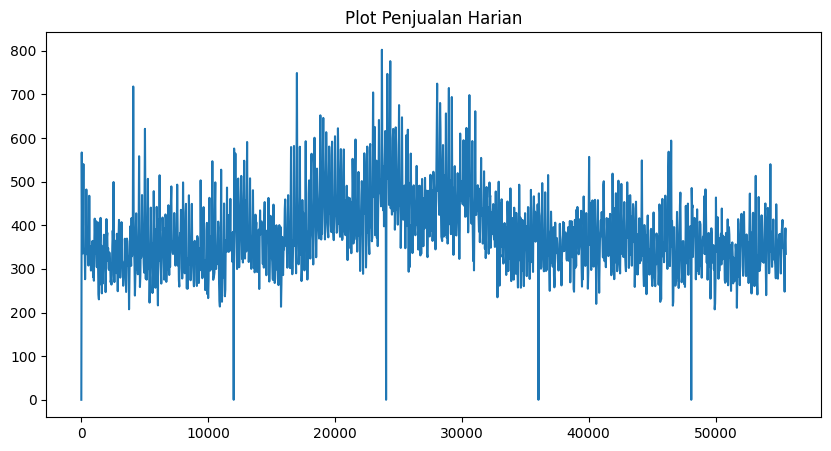

In [24]:
df['sales'].plot(figsize=(10,5), title="Plot Penjualan Harian")

#### Differencing

In [25]:
# pastikan tipe datetime & urut
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.sort_values('date')

# agregasi harian (Bread/Bakery sudah terfilter)
y = df.groupby('date')['sales'].sum()

# (opsional) pastikan tanggal kontigu, isi gap dengan 0
import pandas as pd
full_idx = pd.date_range(y.index.min(), y.index.max(), freq='D')
y = y.reindex(full_idx).fillna(0)
y.name = 'sales'

In [26]:
# differencing (d=1)

y_diff = y.diff().dropna()   # differencing orde-1


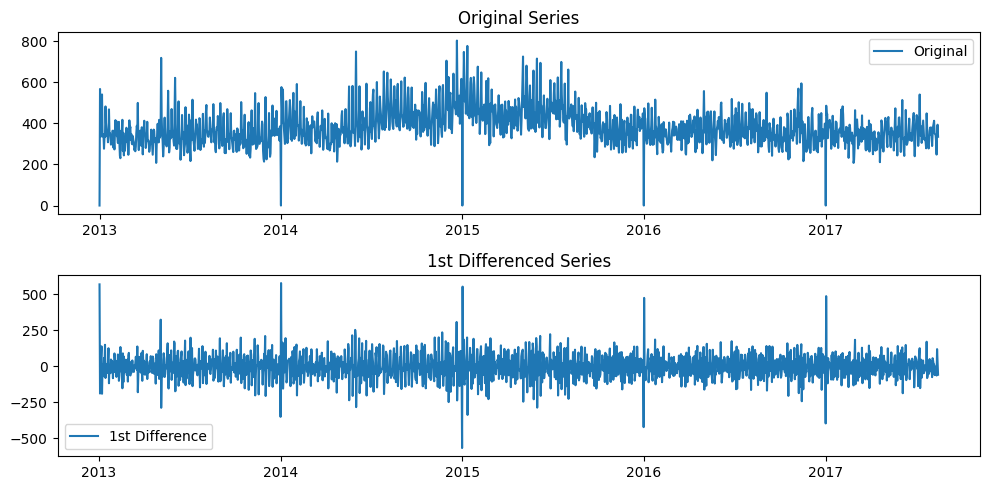

In [27]:
import matplotlib.pyplot as plt

# Original vs Differenced
fig, axes = plt.subplots(2, 1, figsize=(10,5))

# Original series
axes[0].plot(df['date'], df['sales'], label='Original')
axes[0].set_title('Original Series')
axes[0].legend(loc='best')

# 1st Differenced
axes[1].plot(df['date'], df['sales'].diff(), label='1st Difference')
axes[1].set_title('1st Differenced Series')
axes[1].legend(loc='best')

plt.tight_layout()
plt.show()

Differencing digunakan untuk membuat data stasioner. Grafik diatas menunjukkan hasil differencing orde-1 yang lebih stabil dibanding data asli.

# Train Test Split

In [28]:
# Siapkan seri harian yang bersih dan terurut
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.sort_values('date')

y = df.groupby('date')['sales'].sum()
y.name = 'sales'

# Buat indeks harian yang kontigu; TIDAK langsung isi 0
y = y.asfreq('D')

# Time-based split (berdasarkan tanggal cutoff)
y = y.sort_index()
y = y[~y.index.duplicated(keep='first')]

cutoff_pos  = int(len(y) * 0.8)
cutoff_date = y.index[cutoff_pos - 1]          # tanggal terakhir di train

y_train = y.loc[:cutoff_date]
y_test  = y.loc[cutoff_date + pd.Timedelta(days=1):]

print("cutoff_date:", cutoff_date.date(),
      "| len(train) =", len(y_train),
      "| len(test) =", len(y_test))


cutoff_date: 2016-09-11 | len(train) = 1350 | len(test) = 338


# Modelling

### ACF and PACF Plot

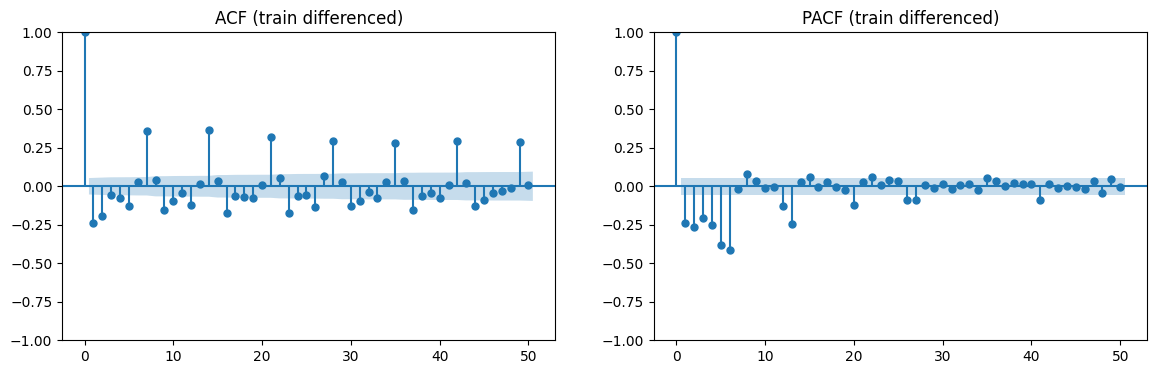

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# differenced series (d=1) untuk melihat p & q
y_train_diff = y_train.diff().dropna()

fig, axes = plt.subplots(1, 2, figsize=(14,4))
plot_acf(y_train_diff, lags=50, ax=axes[0])
axes[0].set_title("ACF (train differenced)")

plot_pacf(y_train_diff, lags=50, ax=axes[1], method='ywm')
axes[1].set_title("PACF (train differenced)")
plt.show()


Kita gunakan ACF (Autocorrelation Function) dan PACF (Partial Autocorrelation Function) untuk membantu menentukan parameter:

* p (AR - Autoregressive): ditentukan dari pola PACF

* q (MA - Moving Average): ditentukan dari pola ACF

* d (Differencing): jumlah differencing untuk membuat data stasioner (sudah dilakukan 1 kali → d = 1)

### Define Order (p, d, q)

* Tahap ini bertujuan menentukan parameter (p,d,q) untuk ARIMA.

* Parameter d = 1 diperoleh dari uji stasioneritas.

* Kandidat nilai p dan q dipilih dari pola ACF dan PACF.

Selanjutnya dilakukan uji coba kombinasi kecil (grid search) untuk memilih model terbaik berdasarkan AIC.

In [30]:
import itertools, warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

p = range(0, 6) # limit menggunakan acuan dari result ACF
d = [1]  # kita targetkan differencing orde-1
q = range(0, 6) # limit menggunakan acuan dari result PACF

best_aic, best_order = np.inf, None
for order in itertools.product(p, d, q):
    try:
        res = ARIMA(y_train, order=order).fit()
        if res.aic < best_aic:
            best_aic, best_order = res.aic, order
    except Exception:
        pass

print("Best ARIMA order (TRAIN):", best_order, "AIC:", best_aic)


Best ARIMA order (TRAIN): (5, 1, 5) AIC: 14903.407018767466


ARIMA(5,1,5) adalah kandidat utama untuk dipakai pada tahap forecasting selanjutnya karena memberikan nilai AIC terkecil di antara kombinasi yang diuji

## ARIMA

In [31]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

# Pakai best_order hasil pencarian Anda; fallback (5,1,5) bila belum ada
order = best_order if ('best_order' in globals() and best_order is not None) else (5, 1, 5)

# Fit hanya di TRAIN
model = ARIMA(y_train, order=order).fit()

# Forecast sepanjang periode TEST
fc_obj = model.get_forecast(steps=len(y_test))
y_hat  = pd.Series(fc_obj.predicted_mean, index=y_test.index)

# 95% confidence interval (opsional untuk plot)
ci = fc_obj.conf_int()
ci.index = y_test.index

Model ini menangkap pola dasar jangka pendek dari data harian, tapi **belum memperhitungkan pola musiman** (misalnya siklus mingguan). Hasil ARIMA bisa digunakan sebagai pembanding terhadap model SARIMA untuk melihat apakah pola musiman memang penting dalam data.

#### Evaluation

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Hapus nilai NaN agar sejajar
mask = (~y_test.isna()) & (~y_hat.isna())
y_test_clean = y_test[mask]
y_hat_clean  = y_hat[mask]

# Hitung metrik evaluasi
mae_arima  = mean_absolute_error(y_test_clean, y_hat_clean)
rmse_arima = np.sqrt(mean_squared_error(y_test_clean, y_hat_clean))

# Gunakan sMAPE (lebih stabil daripada MAPE jika ada nilai 0)
smape_arima = 100 * np.mean(
    2 * np.abs(y_hat_clean - y_test_clean) /
    (np.abs(y_test_clean) + np.abs(y_hat_clean) + 1e-8)
)

# Tampilkan hasil evaluasi
print("ARIMA Evaluation Results")
print(f"Model : ARIMA{order}")
print(f"AIC   : {model.aic:.2f}")
print(f"RMSE  : {rmse_arima:.2f}")
print(f"MAE   : {mae_arima:.2f}")
print(f"sMAPE : {smape_arima:.2f}%")

ARIMA Evaluation Results
Model : ARIMA(5, 1, 5)
AIC   : 14903.41
RMSE  : 56.69
MAE   : 41.57
sMAPE : 12.22%


Hasil evaluasi pada data test menunjukkan:

* RMSE = 56.69 → rata-rata kesalahan prediksi terhadap nilai aktual sekitar **56 satuan penjualan**.

* MAE = 41.27 → rata-rata selisih absolut antara nilai prediksi dan aktual sekitar **41 unit penjualan**.

* sMAPE = 12.18% → kesalahan relatif rata-rata model terhadap skala data sekitar 12.18%.
Nilai ini menunjukkan bahwa prediksi model cukup akurat; dalam konteks data penjualan harian,
**sMAPE di bawah 20% umumnya dianggap baik**.


Model ARIMA(5,1,5) sudah mampu menangkap pola dasar dalam data dengan tingkat kesalahan yang masih wajar.
Namun, model ini belum mempertimbangkan **pola musiman (mingguan/bulanan)**

#### Forecasting

ARIMA Future Forecasts (first 5)
2017-08-16    321.510042
2017-08-17    311.382846
2017-08-18    315.714823
2017-08-19    354.973740
2017-08-20    394.317548
Freq: D, Name: mean, dtype: float64


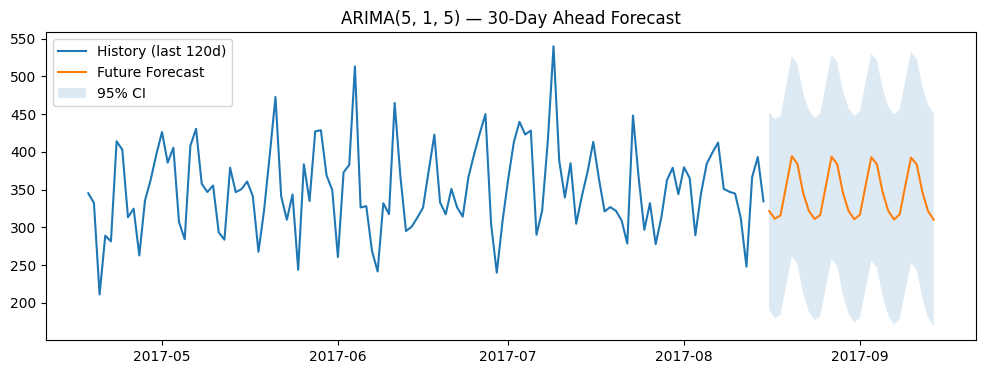

In [33]:
# forecast N hari ke depan
N = 30
final_model = ARIMA(y, order=order).fit()

# Ambil ringkasan forecast lengkap (mean & interval) dengan index otomatis
sf = final_model.get_forecast(steps=N).summary_frame(alpha=0.05)
# Kolom standar: ['mean', 'mean_se', 'mean_ci_lower', 'mean_ci_upper']
y_future  = sf['mean']
ci_lower  = sf['mean_ci_lower']
ci_upper  = sf['mean_ci_upper']

# (Opsional aman untuk data penjualan) nol-batas bawah
y_future = y_future.clip(lower=0)
ci_lower = ci_lower.clip(lower=0)

print("ARIMA Future Forecasts (first 5)")
print(y_future.head())

plt.figure(figsize=(12,4))
plt.plot(y.iloc[-120:], label='History (last 120d)')
plt.plot(y_future, label='Future Forecast')
plt.fill_between(y_future.index, ci_lower, ci_upper, alpha=0.15, label='95% CI')
plt.title(f'ARIMA{order} — {N}-Day Ahead Forecast')
plt.legend(); plt.show()

Model ARIMA(5,1,5) digunakan untuk memproyeksikan penjualan 30 hari ke depan.

Hasil prediksi menunjukkan bahwa penjualan harian diperkirakan tetap stabil di kisaran 320–400 unit per hari, tanpa tren naik atau turun yang signifikan.

Ada peluang sekitar 95% bahwa nilai aktual di masa depan akan berada di dalam rentang ini.

## SARIMA (mingguan)

In [34]:
#!pip uninstall -y numpy scipy scikit-learn pmdarima
#!pip install numpy==1.26.4 scipy==1.13.1 scikit-learn==1.4.2 pmdarima==2.0.4

In [35]:
# SARIMA (Weekly Seasonality)
import itertools, warnings
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

# Non-seasonal order: pakai hasil ARIMA jika ada; fallback ke (5,1,5)
#order = best_order if ('best_order' in globals() and best_order is not None) else (5, 1, 5)
order = (2, 1, 2)

# Grid kecil untuk seasonal order (P,D,Q, s=7)
P = range(0, 3)
D = [0, 1]
Q = range(0, 3)
s = 7

best_aic = np.inf
best_seasonal_order = None
best_res = None

# Grid search kecil
for P_, D_, Q_ in itertools.product(P, D, Q):
    s_order = (P_, D_, Q_, s)
    try:
        res = SARIMAX(
            y_train,
            order=order,
            seasonal_order=s_order,
            trend='n',  # tanpa konstanta, lebih stabil dengan d,D > 0
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False, method='lbfgs', maxiter=500)

        if res.aic < best_aic:
            best_aic = res.aic
            best_seasonal_order = s_order
            best_res = res

    except Exception:
        continue

# Fallback jika semua kombinasi gagal
if best_res is None:
    best_seasonal_order = (0, 1, 1, 7)
    best_res = SARIMAX(
        y_train,
        order=order,
        seasonal_order=best_seasonal_order,
        trend='n',
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

print(f"Best SARIMA seasonal_order (TRAIN): {best_seasonal_order} | AIC: {best_aic:.2f}")

# Fit final model (pakai hasil terbaik)
sarima_model = best_res

# Forecast untuk periode TEST
sarima_fc = sarima_model.get_forecast(steps=len(y_test))
y_hat_sarima = pd.Series(sarima_fc.predicted_mean, index=y_test.index, name="sarima_pred")

# Interval kepercayaan untuk plotting nanti
ci_sarima = sarima_fc.conf_int()
ci_sarima.index = y_test.index

Best SARIMA seasonal_order (TRAIN): (0, 1, 2, 7) | AIC: 14476.41


* Model : SARIMA(2,1,2)×(0,1,2,7)
* AIC : 14476.41 (lebih rendah daripada ARIMA → fit in-sample lebih baik).

Dipilih berdasarkan AIC terendah pada data TRAIN.

Model memasukkan musiman mingguan (s=7) sehingga diharapkan menangkap pola mingguan penjualan lebih baik daripada ARIMA non-musiman.

#### Evaluation

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Bersihkan nilai NaN agar sejajar
mask = (~y_test.isna()) & (~y_hat_sarima.isna())
y_test_clean = y_test[mask]
y_hat_clean  = y_hat_sarima[mask]

# Hitung metrik evaluasi
mae_sarima  = mean_absolute_error(y_test_clean, y_hat_clean)
rmse_sarima = np.sqrt(mean_squared_error(y_test_clean, y_hat_clean))

# sMAPE (Symmetric Mean Absolute Percentage Error)
smape_sarima = 100 * np.mean(
    2 * np.abs(y_hat_clean - y_test_clean)
    / (np.abs(y_test_clean) + np.abs(y_hat_clean) + 1e-8)
)

# Tampilkan hasil evaluasi
print("SARIMA Evaluation Results")
print(f"Model : SARIMA{order}×{best_seasonal_order}")
print(f"AIC   : {sarima_model.aic:.2f}")
print(f"RMSE  : {rmse_sarima:.2f}")
print(f"MAE   : {mae_sarima:.2f}")
print(f"sMAPE : {smape_sarima:.2f}%")

SARIMA Evaluation Results
Model : SARIMA(2, 1, 2)×(0, 1, 2, 7)
AIC   : 14476.41
RMSE  : 56.56
MAE   : 40.28
sMAPE : 11.91%


Hasil evaluasi pada data test menunjukkan:

* RMSE = 56.56 → rata-rata kesalahan prediksi sekitar **56 satuan penjualan** per hari.

* MAE = 40.28 → rata-rata selisih absolut antara prediksi dan data aktual sekitar **40 satuan**.

* sMAPE = 11.91% → tingkat kesalahan relatif yang lebih rendah dibanding ARIMA (14.52%), menandakan model mampu mengikuti pola variasi mingguan dengan baik.

* AIC = 14476.41 → nilai AIC yang lebih kecil dari ARIMA (15309.11), menunjukkan fit yang lebih baik secara statistik.

#### Forecasting

SARIMA Future Forecasts (first 5)
2017-08-16    376.330672
2017-08-17    332.342527
2017-08-18    351.468871
2017-08-19    297.155430
2017-08-20    322.286026
Freq: D, Name: mean, dtype: float64


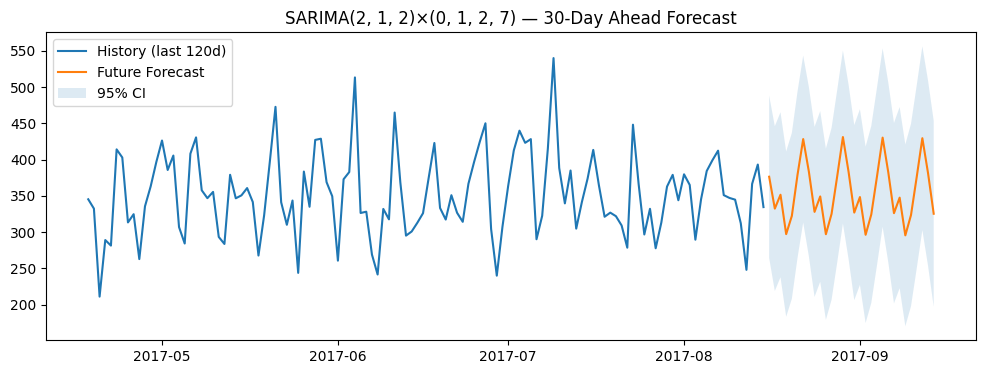

In [37]:
N = 30  # horizon forecast
sf = sarima_model.get_forecast(steps=N).summary_frame(alpha=0.05)

# Ambil komponen utama
y_future  = sf['mean']
ci_lower  = sf['mean_ci_lower']
ci_upper  = sf['mean_ci_upper']

# Tetapkan index waktu kontinu setelah data terakhir
y_future.index = pd.date_range(
    start=y.index[-1] + pd.Timedelta(days=1),
    periods=N, freq='D'
)
ci_lower.index = y_future.index
ci_upper.index = y_future.index

print("SARIMA Future Forecasts (first 5)")
print(y_future.head())

# Plot hasil
plt.figure(figsize=(12,4))
plt.plot(y.iloc[-120:], label='History (last 120d)')
plt.plot(y_future, label='Future Forecast')
plt.fill_between(y_future.index, ci_lower, ci_upper, alpha=0.15, label='95% CI')
plt.title(f'SARIMA{order}×{best_seasonal_order} — {N}-Day Ahead Forecast')
plt.legend()
plt.show()


Model SARIMA(2,1,2)×(0,1,2,7) digunakan untuk memprediksi penjualan selama 30 hari ke depan dengan mempertimbangkan pola musiman mingguan.
Hasil prediksi menunjukkan adanya fluktuasi mingguan yang jelas, di mana penjualan harian diperkirakan akan berada pada kisaran 300–400 unit per hari.

Secara umum, model ini mampu menangkap pola periodik mingguan dengan cukup baik tanpa adanya lonjakan ekstrem atau penurunan tajam.
Hal ini menunjukkan bahwa penjualan bersifat musiman mingguan yang relatif stabil, dan model SARIMA memberikan proyeksi yang lebih realistis dibandingkan model ARIMA non-musiman.

## Forecasting ARIMA vs SARIMA

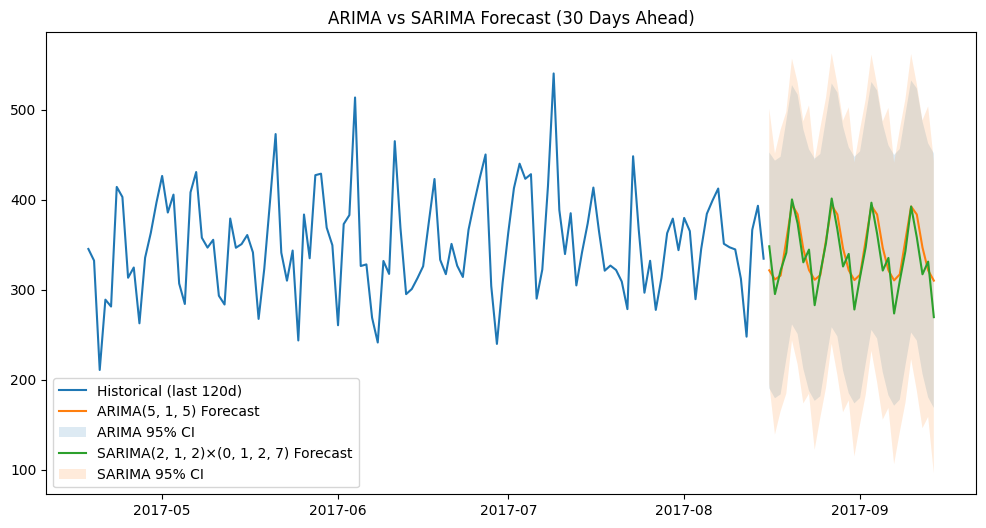

In [38]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd

# --- Set model dari hasil seleksi sebelumnya ---
arima_order = (5,1,5)                     # mis. (2,1,2) dari grid ARIMA Anda
sarima_order = order                    # nonseasonal sama
seasonal_order = best_seasonal_order    # mis. (0,1,2,7) dari grid SARIMA

# --- Horizon forecast ---
N = 30
future_idx = pd.date_range(start=y.index[-1] + pd.Timedelta(days=1), periods=N, freq='D')

# --- Forecast ARIMA (fit di FULL y) ---
arima_full = ARIMA(y, order=arima_order).fit()
arima_sf   = arima_full.get_forecast(steps=N).summary_frame()
arima_pred = arima_sf['mean']; arima_pred.index = future_idx
arima_lo   = arima_sf['mean_ci_lower']; arima_lo.index = future_idx
arima_hi   = arima_sf['mean_ci_upper']; arima_hi.index = future_idx

# --- Forecast SARIMA (fit di FULL y) ---
sarima_full = SARIMAX(y, order=sarima_order, seasonal_order=seasonal_order,
                      trend='n', enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
sarima_sf   = sarima_full.get_forecast(steps=N).summary_frame()
sarima_pred = sarima_sf['mean']; sarima_pred.index = future_idx
sarima_lo   = sarima_sf['mean_ci_lower']; sarima_lo.index = future_idx
sarima_hi   = sarima_sf['mean_ci_upper']; sarima_hi.index = future_idx

# --- Plot hasil ---
plt.figure(figsize=(12,6))
plt.plot(y.index[-120:], y.iloc[-120:], label='Historical (last 120d)')

plt.plot(arima_pred.index, arima_pred, label=f'ARIMA{arima_order} Forecast')
plt.fill_between(arima_pred.index, arima_lo, arima_hi, alpha=0.15, label='ARIMA 95% CI')

plt.plot(sarima_pred.index, sarima_pred, label=f'SARIMA{sarima_order}×{seasonal_order} Forecast')
plt.fill_between(sarima_pred.index, sarima_lo, sarima_hi, alpha=0.15, label='SARIMA 95% CI')

plt.title('ARIMA vs SARIMA Forecast (30 Days Ahead)')
plt.legend(); plt.show()

**Kesimpulan ARIMA vs SARIMA:**

Hasil perbandingan menunjukkan bahwa model SARIMA(2,1,2)×(0,1,2,7) memberikan hasil yang lebih realistis dibandingkan ARIMA(2,1,2).

SARIMA berhasil menangkap pola musiman mingguan yang tidak ditangkap oleh ARIMA, sehingga proyeksi penjualan tampak lebih dinamis dan mendekati perilaku aktual data.

Berdasarkan nilai AIC yang lebih rendah serta pola prediksi yang lebih alami, SARIMA dipilih sebagai baseline musiman terbaik sebelum dilakukan pemodelan berbasis jaringan saraf seperti LSTM.

In [39]:
# review data yang dapat digunakan untuk LSTM
df.head()          # 5 baris pertama
df.head(10)        # 10 baris pertama
df.tail()          # 5 baris terakhir
df.sample(10)      # 10 baris acak


,id,date,store_nbr,family,sales,month,dayofweek
30200,1631987,2015-07-07,5,BREAD/BAKERY,444.28900,7,1
51155,2763557,2017-04-04,5,BREAD/BAKERY,354.68300,4,1
36107,1950965,2016-01-03,5,BREAD/BAKERY,430.98900,1,6
10796,584171,2013-11-24,5,BREAD/BAKERY,408.40700,11,6
10730,580607,2013-11-22,5,BREAD/BAKERY,321.85300,11,4
37328,2016899,2016-02-09,5,BREAD/BAKERY,268.13200,2,1
6671,361421,2013-07-22,5,BREAD/BAKERY,416.54102,7,0
38252,2066795,2016-03-08,5,BREAD/BAKERY,323.50600,3,1
19277,1042145,2014-08-09,5,BREAD/BAKERY,504.60100,8,5
30167,1630205,2015-07-06,5,BREAD/BAKERY,518.53500,7,0


## LSTM

# Feature Engineering
Menambahkan informasi waktu (fitur) ke dalam data untuk membantu model LSTM mengenali pola musiman (tahunan, bulanan, mingguan).

In [40]:
y = df.groupby('date')['sales'].sum().asfreq('D').fillna(0)
data_df = y.to_frame(name='sales')

# Tambahkan fitur-fitur baru dari indeks tanggal
data_df['day_of_week'] = data_df.index.dayofweek # Senin=0, Minggu=6
data_df['day_of_year'] = data_df.index.dayofyear # 1-366
# data_df['week_of_year'] = data_df.index.isocalendar().week
data_df['month'] = data_df.index.month
data_df['year'] = data_df.index.year

print("Data dengan Fitur-Fitur Baru (5 baris pertama):")
display(data_df.head())

Data dengan Fitur-Fitur Baru (5 baris pertama):


,sales,day_of_week,day_of_year,month,year
date,,,,,
2013-01-01,0.000,1,1,1,2013
2013-01-02,566.917,2,2,1,2013
2013-01-03,377.887,3,3,1,2013
2013-01-04,335.761,4,4,1,2013
2013-01-05,402.286,5,5,1,2013


# Preprosesing Data
* scaling data menggunakan minmax scaller
* membuat fungsi untuk urutan lookback dari sequence untuk data latih dengan asumsi look back adalah 30 hari kebelakang untuk melihat pertumbuhan penjualan selama 1 bulan terakhir
* membuat test split dan data latih 80% dan data test 20%

In [41]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Scaling Data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_df)

# Fungsi untuk membuat sequences
def create_multivariate_sequences(data, sales_col_index, look_back=30):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :])
        y.append(data[i + look_back, sales_col_index])
    return np.array(X), np.array(y)

look_back = 30
sales_col_index = 0 # Kolom 'sales' ada di indeks 0

# Train-Test Split & Reshape
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - look_back:]

X_train, y_train_lstm = create_multivariate_sequences(train_data, sales_col_index, look_back)
X_test, y_test_lstm = create_multivariate_sequences(test_data, sales_col_index, look_back)

print(f"\nBentuk X_train setelah di-sequence: {X_train.shape}")
print(f"Bentuk y_train_lstm setelah di-sequence: {y_train_lstm.shape}")
print(f"Bentuk X_test setelah di-sequence: {X_test.shape}")
print(f"Bentuk y_test_lstm setelah di-sequence: {y_test_lstm.shape}")


Bentuk X_train setelah di-sequence: (1320, 30, 5)
Bentuk y_train_lstm setelah di-sequence: (1320,)
Bentuk X_test setelah di-sequence: (338, 30, 5)
Bentuk y_test_lstm setelah di-sequence: (338,)


# Membangun Arsitektur Model LSTM
membangun model sequential untuk membentuk 2 lapis model LSTM dengan dropout 20% untuk menghindari overfitting
* lapisan pertama digunakan untuk mempelajari data mentah dari dengan format shape 30 hari lookback dan neuron 100
* lapisan kedua yaitu mempelajari hasil output dari lapisan pertama
* lapisan dense untuk membuat output terakhir dari lapisan kedua

In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

tf.random.set_seed(42) # Agar hasil training bisa konsisten jika dijalankan ulang

model_lstm = Sequential()
model_lstm.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(100))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))

model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 100)        │        42,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,901 (480.08 KB)

 Trainable params: 122,901 (480.08 KB)

 Non-trainable params: 0 (0.00 B)

### LSTM Training
Penggunaan Early stop untuk menjaga agar data tidak overfitting dengan asumsi nilai patience adalah 30 epoch apabila tidak ada peningkatan

In [43]:
from tensorflow.keras.callbacks import EarlyStopping

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Callback untuk menghentikan training jika tidak ada peningkatan
early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)

print("\nMemulai Training Model LSTM...")
history = model_lstm.fit(
    X_train,
    y_train_lstm,
    epochs=200,
    batch_size=32,
    validation_data=(X_test, y_test_lstm),
    verbose=1,
    callbacks=[early_stop]
)


Memulai Training Model LSTM...
Epoch 1/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 0.9690 - val_loss: 0.5618
Epoch 2/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.9031 - val_loss: 0.5409
Epoch 3/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.8372 - val_loss: 0.5072
Epoch 4/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.7222 - val_loss: 0.4645
Epoch 5/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.6332 - val_loss: 0.4518
Epoch 6/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.5969 - val_loss: 0.4276
Epoch 7/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.5468 - val_loss: 0.4415
Epoch 8/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.5494 - val_loss: 0.4331
Epoch 9/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.5513 - val_loss: 0.4270
Epoch 10/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.5344 - val_loss: 0.4214
Epoch 11/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.5305 - val_loss: 0.4153
Epoch 12/200
42/42 ━

### Evaluation
Dengan adanya data 0 dalam timeseries, akan membuat hasil perhitungan MAPE menjadi tidak relevan karena menyebabkan faktor kalkulasi yang mendekati hasil tidak terbatas.
adapun metode untuk evaluasi adalah menggunakan sMAPE untuk menghindari pembagian dengan 0.
Rumus SMAPE tidak melibatkan pembagian dengan nilai aktual, sehingga tidak akan menghasilkan kesalahan tak terhingga (infinity) ketika nilai aktual adalah nol, sebuah kelemahan pada MAPE.

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Prediksi pada data test
test_predict = model_lstm.predict(X_test)

# Inverse transform prediksi agar kembali ke skala asli
test_predict_full = np.zeros(shape=(len(test_predict), data_df.shape[1]))
test_predict_full[:, 0] = test_predict.flatten()
test_predict_inv = scaler.inverse_transform(test_predict_full)[:, 0]

# Inverse transform y_test_lstm untuk perbandingan
y_test_full = np.zeros(shape=(len(y_test_lstm), data_df.shape[1]))
y_test_full[:, 0] = y_test_lstm.flatten()
y_test_inv = scaler.inverse_transform(y_test_full)[:, 0]

# Hitung metrik evaluasi
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, test_predict_inv))
mae_lstm = mean_absolute_error(y_test_inv, test_predict_inv)

def calculate_smape(actual, predicted):
    # Buat salinan untuk menghindari perubahan pada data asli
    actual_safe = actual.copy()
    predicted_safe = predicted.copy()

    # Handle kasus di mana aktual dan prediksi sama-sama nol
    numerator = 2 * np.abs(predicted_safe - actual_safe)
    denominator = np.abs(actual_safe) + np.abs(predicted_safe)

    # Penggunaan kondisi apabila 0 langsung di ambil nilainya, tapi apabila bukan 0 menggunakan perhitungan
    ratio = np.where(denominator == 0, 0, numerator / denominator)

    return np.mean(ratio) * 100

# Hitung sMAPE menggunakan fungsi di atas
smape_lstm = calculate_smape(y_test_inv, test_predict_inv)

print("\n--- LSTM Evaluation Results ---")
print(f"RMSE: {rmse_lstm:.2f}")
print(f"MAE : {mae_lstm:.2f}")
print(f"SMAPE: {smape_lstm:.2f}%")


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

--- LSTM Evaluation Results ---
RMSE: 57.11
MAE : 39.27
SMAPE: 11.83%


# Plot Hasil Evaluasi

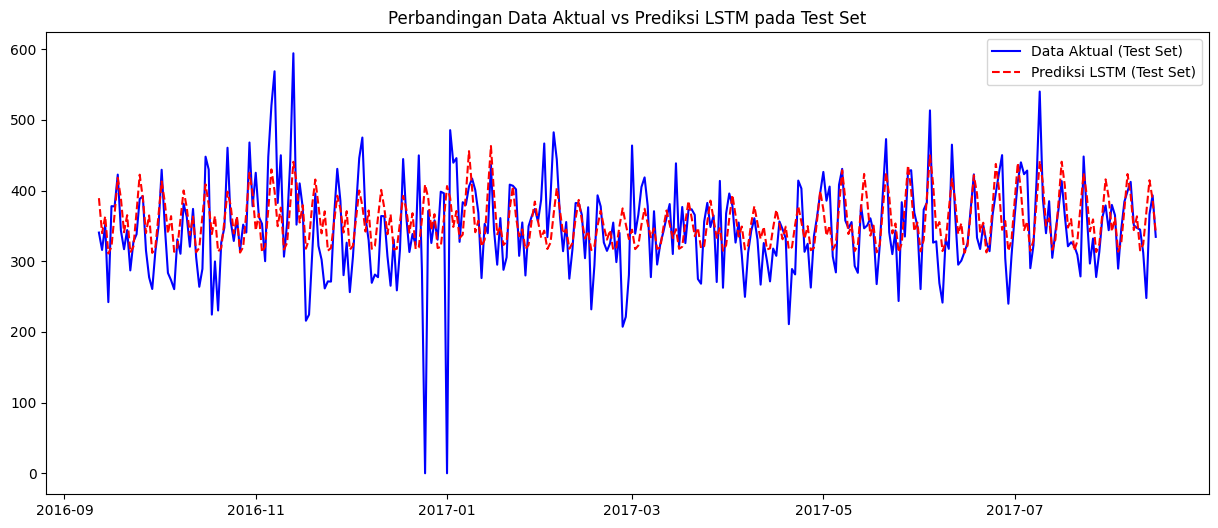

In [45]:
# Plot hasil evaluasi
plt.figure(figsize=(15, 6))
plt.plot(data_df.index[train_size:], y_test_inv, label='Data Aktual (Test Set)', color='blue')
plt.plot(data_df.index[train_size:], test_predict_inv, label='Prediksi LSTM (Test Set)', color='red', linestyle='--')
plt.title('Perbandingan Data Aktual vs Prediksi LSTM pada Test Set')
plt.legend()
plt.show()

### Forecasting (Optional)

In [46]:
# Ambil data terakhir dari dataset untuk memulai prediksi
last_sequence = scaled_data[-look_back:]
current_batch = last_sequence.reshape(1, look_back, data_df.shape[1])

# List untuk menyimpan prediksi
future_predictions_scaled = []

# Buat fitur tanggal untuk 30 hari ke depan
future_period = 30
future_dates = pd.date_range(start=data_df.index[-1] + pd.Timedelta(days=1), periods=future_period)

for date in future_dates:
    # Prediksi step berikutnya
    current_pred = model_lstm.predict(current_batch)[0]
    future_predictions_scaled.append(current_pred)

    # Buat fitur baru untuk tanggal prediksi
    new_features = np.array([[
        current_pred[0], # Ini adalah placeholder, akan diisi oleh prediksi itu sendiri
        date.dayofweek,
        date.dayofyear,
        date.month,
        date.year
    ]])

    # Scale fitur baru
    scaled_new_features = scaler.transform(new_features)

    # Update batch: buang data pertama, tambahkan prediksi baru di akhir
    # Kolom pertama (sales) dari fitur baru diganti dengan hasil prediksi
    scaled_new_features[0, 0] = current_pred
    current_batch = np.append(current_batch[:, 1:, :], [scaled_new_features], axis=1)

# Inverse transform hasil prediksi
future_predictions_full = np.zeros(shape=(len(future_predictions_scaled), data_df.shape[1]))
future_predictions_full[:, 0] = np.array(future_predictions_scaled).flatten()
future_predictions = scaler.inverse_transform(future_predictions_full)[:, 0]

forecast_df = pd.DataFrame({
    'date': future_dates,
    'forecast_sale': future_predictions.flatten() # .flatten() untuk memastikan datanya 1D
})
forecast_bakery = forecast_df.set_index('date')
forecast_bakery

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

,forecast_sale
date,
2017-08-16,361.128506
2017-08-17,313.946117
2017-08-18,321.644172
2017-08-19,364.549005
2017-08-20,411.152393
2017-08-21,389.228587
2017-08-22,343.083141
2017-08-23,363.994753
2017-08-24,315.465521


# Grafik forecasting 30 hari kedepan

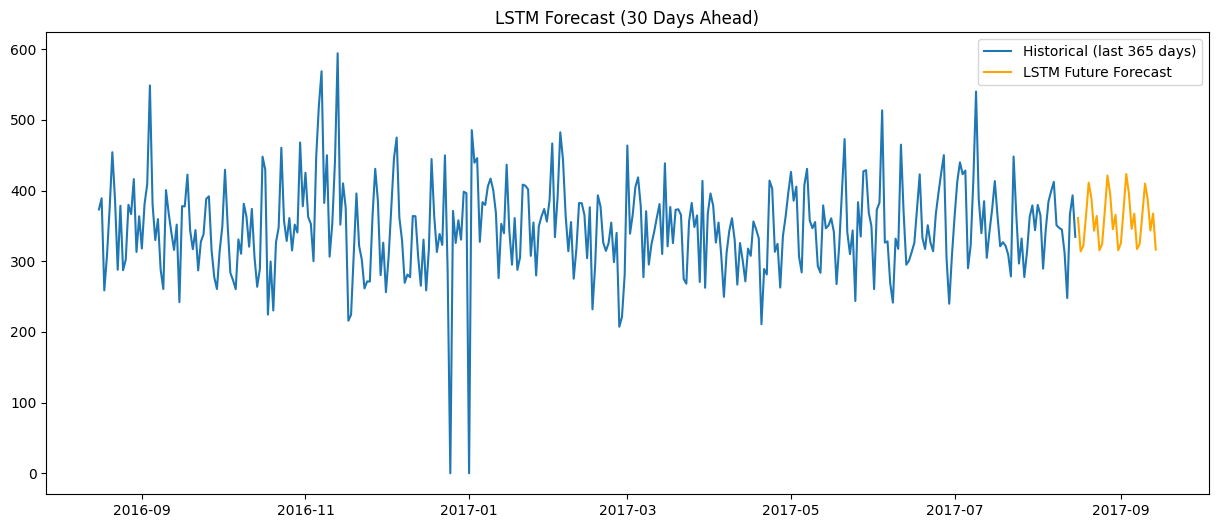

In [47]:
# Plot hasil forecasting
plt.figure(figsize=(15, 6))
plt.plot(data_df.index[-365:], data_df['sales'].values[-365:], label='Historical (last 365 days)')
plt.plot(future_dates, future_predictions, label='LSTM Future Forecast', color='orange')
plt.title(f'LSTM Forecast ({future_period} Days Ahead)')
plt.legend()
plt.show()

# Comparison Model

In [48]:
comparison_data = {
    'Model': ['ARIMA', 'SARIMA', 'LSTM (Multivariate)'],
    'RMSE': [rmse_arima, rmse_sarima, rmse_lstm],
    'MAE': [mae_arima, mae_sarima, mae_lstm],
    'sMAPE (%)': [smape_arima, smape_sarima, smape_lstm]
}
comparison_df = pd.DataFrame(comparison_data).set_index('Model')

# tabel perbandingan
print("\n--- Tabel Perbandingan Performa Model ---")
display(comparison_df.round(2))


--- Tabel Perbandingan Performa Model ---


,RMSE,MAE,sMAPE (%)
Model,,,
ARIMA,56.69,41.57,12.22
SARIMA,56.56,40.28,11.91
LSTM (Multivariate),57.11,39.27,11.83
